# Исследование данных HR-агенства

## 1. Постановка задачи
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа необходимо:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. Ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


Для этого проведем анализ датасета с зарплатами в сфере Data Science.

Данные содержат следующие столбцы:

* work_year - год, в котором была выплачена зарплата.
* experience_level - опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
* employment_type - тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
* job_title - роль, в которой соискатель работал в течение года.
* salary - общая выплаченная валовая сумма заработной платы.
* salary_currency - валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd - зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio - общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
* company_location - страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

***

## 2. Загрузка данных

In [1724]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [1725]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col = 'Unnamed: 0')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [1726]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


***

## 3. Описательный анализ данных

#### 3.1. Найдем пропущенные значения в датасете:

In [1727]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


Видим, что в датасете 607 записей. Нет пропущенных значений.

#### 3.2 Проверим данные на наличие полных дубликатов:

In [1728]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:

data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


#### 3.3. Проверим корректность типов данных столбцов:

In [1729]:
# Исправим тип данных в столбце remote_ratio с int64 на object:

data['remote_ratio'] = data['remote_ratio'].astype(object)

# Проверим тип данных после изменения: 

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary              565 non-null    int64 
 5   salary_currency     565 non-null    object
 6   salary_in_usd       565 non-null    int64 
 7   employee_residence  565 non-null    object
 8   remote_ratio        565 non-null    object
 9   company_location    565 non-null    object
 10  company_size        565 non-null    object
dtypes: int64(3), object(8)
memory usage: 53.0+ KB


#### 3.4. Найдем неинформативные признаки, которые можно сразу удалить, чтобы не загружать датасет лишней информацией.

Проанализировав ключевые вопросы от HR-агенства и признаки, имеющиеся в датасете, выявим следующие признаки, которые не пригодятся в исследовании:

* salary - общая выплаченная валовая сумма заработной платы.
* salary_currency - валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.

In [1730]:
data = data.drop(['salary', 'salary_currency'], axis = 1)

#### 3.5. Классифицируем все признаки на числовые и категориальные, чтобы корректно провести статистический анализ:

**Числовые признаки:**

* work_year - год, в котором была выплачена зарплата;
* salary_in_usd - зарплата в долларах США;

**Категориальные признаки:**

* experience_level - опыт работы на этой должности в течение года;
* employment_type - тип трудоустройства для этой роли;
* job_title - роль, в которой соискатель работал в течение года;
* employee_residence - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
* remote_ratio - общий объём работы, выполняемой удалённо;
* company_location - страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - среднее количество людей, работавших в компании в течение года.

#### 3.6. Найдем основные статистические характеристики для каждого из признаков:

In [1731]:
# Признак work_year:
data_w_y_describe = data['work_year'].describe().round(2).to_frame()
data_w_y_describe.columns = ['Год, в котором была выплачена з/п']
data_w_y_describe

,"Год, в котором была выплачена з/п"
count,565.00
mean,2021.36
std,0.70
min,2020.00
25%,2021.00
50%,2021.00
75%,2022.00
max,2022.00


Заметим, что в данных нет лишних значений, которые бы не относились к условиям анализа - т.е. года представлены с 2020 по 2022.

In [1732]:
# Признак experience_level:
data_e_l_describe = data['experience_level'].describe().to_frame()
data_e_l_describe.columns = ['Опыт работы на должности в течение года']
data_e_l_describe

,Опыт работы на должности в течение года
count,565
unique,4
top,SE
freq,243


Для категориальных признаков количество статистических характеристик намного меньше. Всего уникальных значений - 4. Самое частое - SE (Senior-level/Expert), оно повторяется 243 раза.

In [1733]:
# Признак employment_type:
data_e_t_describe = data['employment_type'].describe().to_frame()
data_e_t_describe.columns = ['Тип трудоустройства']
data_e_t_describe

,Тип трудоустройства
count,565
unique,4
top,FT
freq,546


Уникальных значений - 4. Самое частое - FT - полный рабочий день (546 раз)

In [1734]:
# Признак job_title:
data_j_t_describe = data['job_title'].describe().to_frame()
data_j_t_describe.columns = ['Роль, в которой соискатель работал в течение года']
data_j_t_describe

,"Роль, в которой соискатель работал в течение года"
count,565
unique,50
top,Data Scientist
freq,130



Уникальных значений - 50. Самое частое - Data Scientist (130 раз)

In [1735]:
# Признак salary_in_usd:
data_s_u_describe = data['salary_in_usd'].describe().round(2).to_frame()
data_s_u_describe.columns = ['Зарплата в долларах США']
data_s_u_describe

,Зарплата в долларах США
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Среднее значение зарплаты по всему датасету - 110 610.34 долларов США

In [1736]:
# Признак employee_residence:
data_e_r_describe = data['employee_residence'].describe().to_frame()
data_e_r_describe.columns = ['Основная страна проживания сотрудника в течение рабочего года']
data_e_r_describe

,Основная страна проживания сотрудника в течение рабочего года
count,565
unique,57
top,US
freq,295


Уникальных значений - 57. Самое частое - US (295 раз)

In [1737]:
# Признак remote_ratio:
data_r_r_describe = data['remote_ratio'].describe().round(2).to_frame()
data_r_r_describe.columns = ['Общий объем работы, выполняемой удаленно']
data_r_r_describe

,"Общий объем работы, выполняемой удаленно"
count,565
unique,3
top,100
freq,346


Уникальный значений - 3. Самое частое - 100 % выполняемой работы удаленно (346 раз)

In [1738]:
# Признак company_location:
data_c_l_describe = data['company_location'].describe().to_frame()
data_c_l_describe.columns = ['Cтрана главного офиса работодателя или филиала по контракту']
data_c_l_describe

,Cтрана главного офиса работодателя или филиала по контракту
count,565
unique,50
top,US
freq,318


Уникальных значений - 50. Самое частое - US (318 раз)

In [1739]:
# Признак company_size:
data_c_z_describe = data['company_size'].describe().to_frame()
data_c_z_describe.columns = ['Cреднее количество людей, работавших в компании в течение года']
data_c_z_describe

,"Cреднее количество людей, работавших в компании в течение года"
count,565
unique,3
top,M
freq,290


Уникальных значений - 3. Самое частое - M - средняя компания от 50 до 250 сотрудников (290 раз)

***

## 4. Разведывательный анализ данных
### 4.1 Визуальный анализ основных данных

#### 4.1.1 Распределение заплаты специалиста Data Scientist

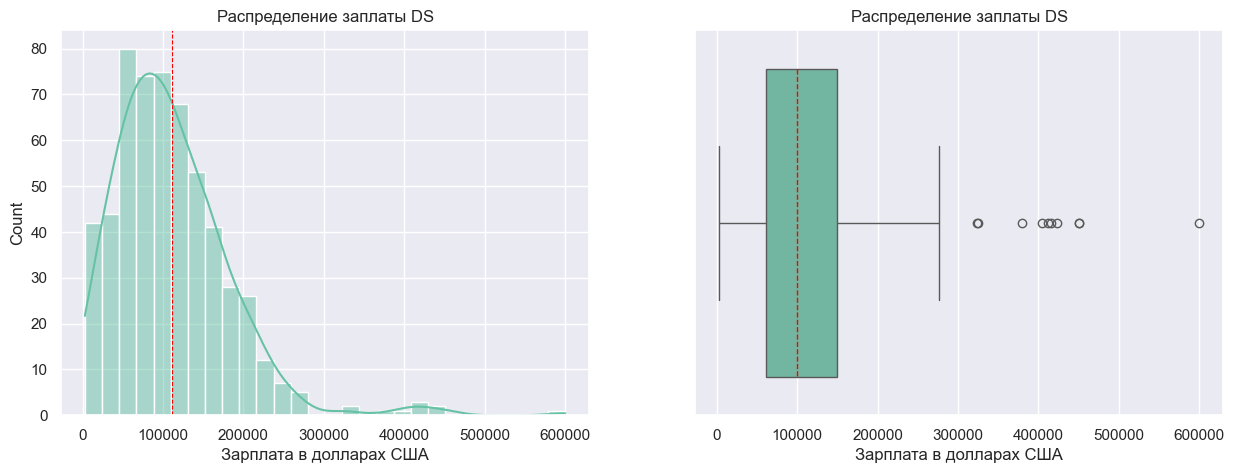

In [1740]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Создадим первый график - гистрограмму распределения; устанавливаем параметр kde = True, чтобы вычислить оценку плотности ядра, 
# чтобы сгладить распределение и отобразить на графике в виде линии:

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США')
axes[0].set_title('Распределение заплаты DS')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата в долларах США')
axes[1].set_title('Распределение заплаты DS')

plt.show()

In [1741]:
# Признак salary_in_usd:
data_s_u_describe = data['salary_in_usd'].describe().round(2).to_frame()
data_s_u_describe.columns = ['Зарплата в долларах США']
data_s_u_describe

,Зарплата в долларах США
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


#### Вывод по графику:
Распределение немного приближено к нормальному, но есть выбросы (начиная от 300 000 долларов США). Медианное значение практически равно среднему - 100 000 долларов США.

***

#### 4.1.2 Как изменялась зарплата специалиста Data Scientist 2020-2022гг

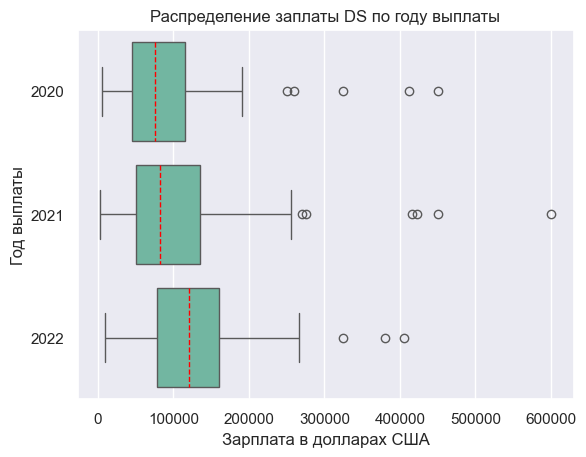

In [1742]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в долларах США', ylabel='Год выплаты')
plt.title('Распределение заплаты DS по году выплаты')
plt.show()

In [1743]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение заплаты DS по году выплаты')
data_agg

Распределение заплаты DS по году выплаты


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


#### Вывод по графику:
Выводы: можно отметить рост медианной и средней зарплаты с 2020 по 2022 гг. Особенно виден рост зарплат в 2022 году, где нижний квантиль немного меньше, чем верхний в 2020 и 2021 году.

Также отметим выброс в 2020 году - зарплата 412 000 долларов.

***

## Какие факторы влияют на зарплату специалиста Data Scientist?

### 4.2. Базовый анализ каждого признака, участвующего в исследовании

#### 4.2.1 Влияет ли опыт работы на зарплату специалиста Data Scientist?

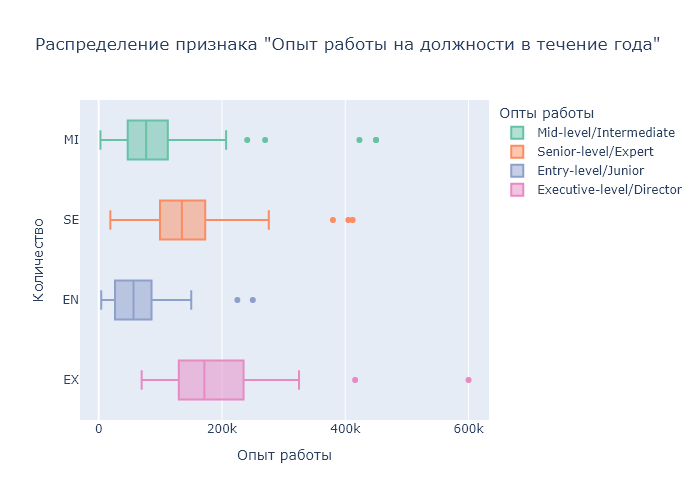

In [1744]:
fig = px.box(
    data,
    x='salary_in_usd',
    y = 'experience_level', 
    title = 'Распределение признака "Опыт работы на должности в течение года"', 
    labels = {'experience_level': 'Опты работы'},
    color = 'experience_level', 
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig.update_layout(xaxis_title_text = 'Опыт работы', yaxis_title_text='Количество')
newnames = {'EN':'Entry-level/Junior', 'EX': 'Executive-level/Director', 'MI':'Mid-level/Intermediate', 'SE':'Senior-level/Expert'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show('png')

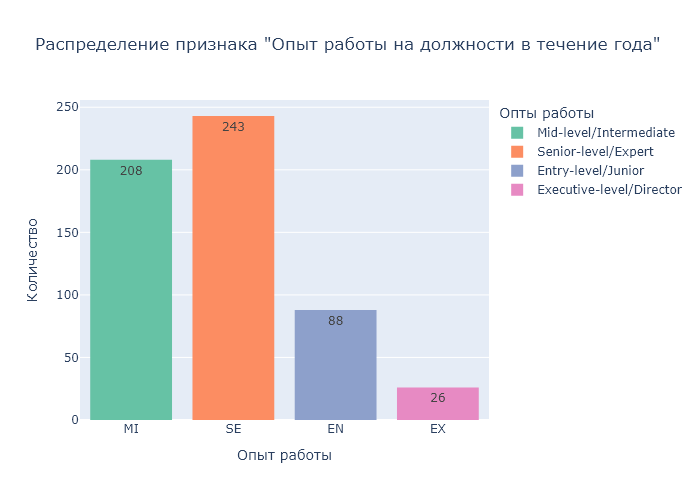

In [1745]:
# Чтобы визуально оценить распределение опыта работы построим гистограммы c помощью метода px.histogram библиотеки plotly.express. 
# Выставим параметр text_auto = True, чтобы на графике отобразить количество записей для каждой категории:

fig = px.histogram(data, x = 'experience_level', title = 'Распределение признака "Опыт работы на должности в течение года"', 
                   labels = {'experience_level': 'Опты работы'}, text_auto = True, color = 'experience_level', 
                   color_discrete_sequence = px.colors.qualitative.Set2)
fig.update_layout(xaxis_title_text = 'Опыт работы', yaxis_title_text='Количество')
newnames = {'EN':'Entry-level/Junior', 'EX': 'Executive-level/Director', 'MI':'Mid-level/Intermediate', 'SE':'Senior-level/Expert'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show('png')

In [1746]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение заплаты DS в зависимости от опыта работы')
data_agg

Распределение заплаты DS в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0


#### Вывод по графику:
 Больше всего в датасете специалистов с категорией опыта работы SE (Senior-level/Expert), меньше всего - EX (Executive-level/Director).

***

#### 4.2.2 Влияет ли тип трудоустройства на зарплату специалиста Data Scientist?

In [1747]:
fig = px.box(
    data, 
    x = 'salary_in_usd', 
    y='employment_type',
    height=500, 
    width=900,
    title = 'Распределение признака "Тип трудоустройства"', 
    labels = {'employment_type': 'Тип трудоустройства'},
    color = 'employment_type',
    color_discrete_sequence = px.colors.qualitative.Set2
   
)
fig.update_layout(xaxis_title_text = 'Тип трудоустройства', yaxis_title_text='Количество')
newnames = {'PT':'Неполный рабочий день', 'FT': 'Полный рабочий день', 'CT':'Контракт', 'FL':'Фриланс'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show()

In [1748]:
# Аналогично построим гистограмму распределения типа трудоустройства:

fig = px.histogram(
    data, 
    x = 'employment_type', 
    height=500, 
    width=900,
    title = 'Распределение признака "Тип трудоустройства"', 
    labels = {'employment_type': 'Тип трудоустройства'},
    text_auto = True,
    color = 'employment_type',
    color_discrete_sequence = px.colors.qualitative.Set2
   
)
fig.update_layout(xaxis_title_text = 'Тип трудоустройства', yaxis_title_text='Количество')
newnames = {'PT':'Неполный рабочий день', 'FT': 'Полный рабочий день', 'CT':'Контракт', 'FL':'Фриланс'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show()

In [1749]:
data_agg = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Распределение заплаты DS в зависимости от типа трудоустройства')
data_agg

Распределение заплаты DS в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.0,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.0,40000.0,70000.0,100000.0
FT,546.0,111811.84,70790.70,2859.0,62726.0,100000.0,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.0,18817.5,48370.0,100000.0


#### Вывод по графику: 
Подавляющие большинство специалистов работают по графику FT (полный рабочий день), поэтому данный признак может не иметь влияния на заработную плату в сфере Data Science, и его можно не использовать в исследовании.

***

#### 4.2.3 Влияет ли роль, в которой соискатель работал в течение года, на зарплату специалиста Data Scientist?

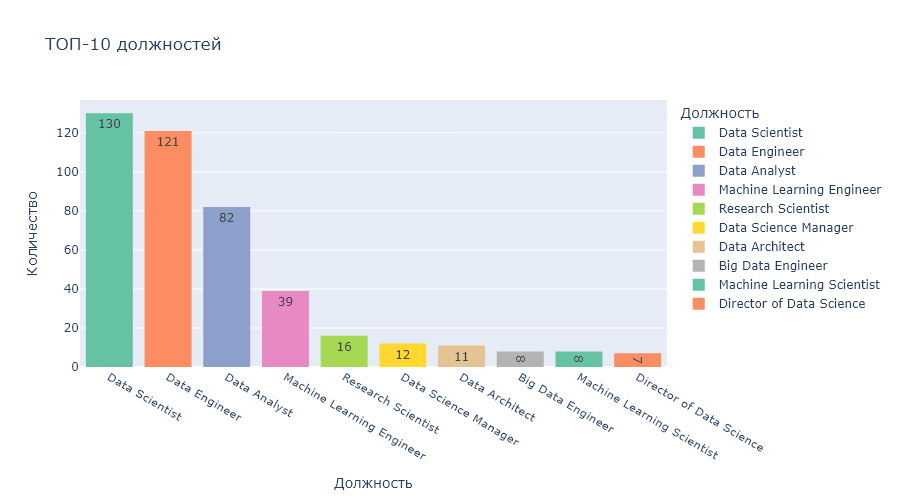

In [1750]:
grouped = data.groupby(['job_title'])['salary_in_usd'].count().sort_values(ascending=False)

grouped=grouped.head(10)
fig = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'ТОП-10 должностей',
    labels = {'job_title': 'Должность'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig.update_layout(xaxis_title_text = 'Должность', yaxis_title_text='Количество')
fig.show('png')

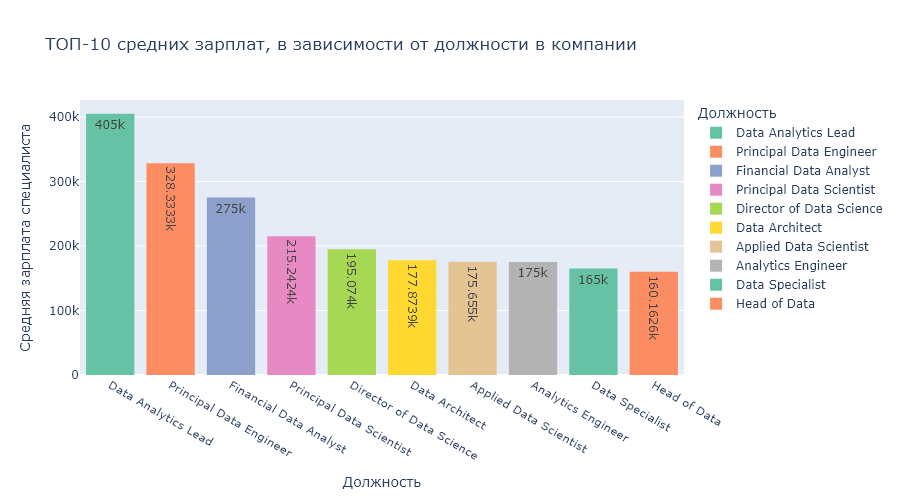

In [1751]:
grouped = data.groupby(['job_title'])['salary_in_usd'].mean().sort_values(ascending=False)

grouped=grouped.head(10)
fig = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    height=500, #высота
    width=900, #ширина
    labels = {'job_title': 'Должность'},
    title = 'ТОП-10 средних зарплат, в зависимости от должности в компании',
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig.update_layout(xaxis_title_text = 'Должность', yaxis_title_text='Средняя зарплата специалиста')
fig.show('png')

#### Вывод по графику: 
Cамые популярные профессии в сфере Data Science за 2020-2022 гг. - Data Scientist (130 человек), Data Engineer (121 человек), Data Analyst (82 человека). 

И для своего любопытсва был построен график ТОП-10 средних зарплат в зависимости от роли в компании. Лидирующие позиции занимают:
1. Data Analytics Lead - 405к
2. Principal Data Engineer - 328к
3. Financial Data Analyst - 275к

***

#### 4.2.3 Влияет ли страна проживания на зарплату специалиста Data Scientist?

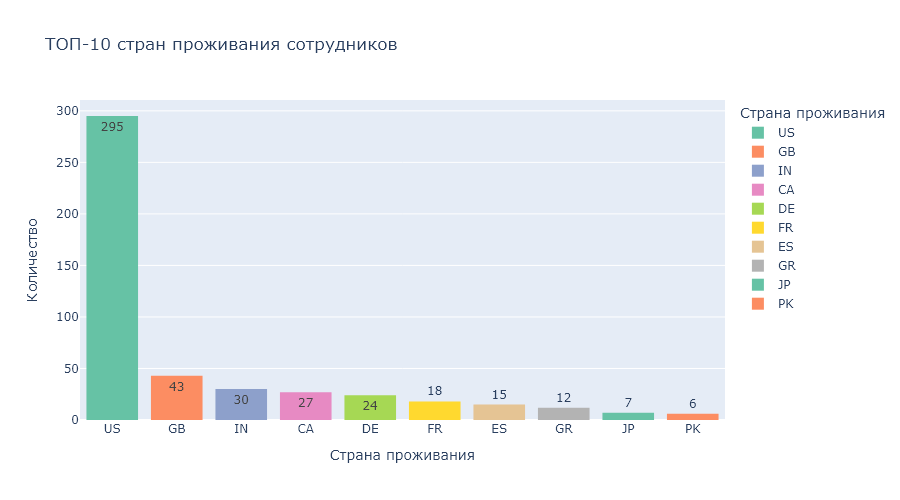

In [1752]:
grouped = data.groupby(['employee_residence'])['salary_in_usd'].count().sort_values(ascending=False)

grouped=grouped.head(10)
fig = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'ТОП-10 стран проживания сотрудников',
    labels = {'employee_residence': 'Страна проживания'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig.update_layout(xaxis_title_text = 'Страна проживания', yaxis_title_text='Количество')
fig.show('png')

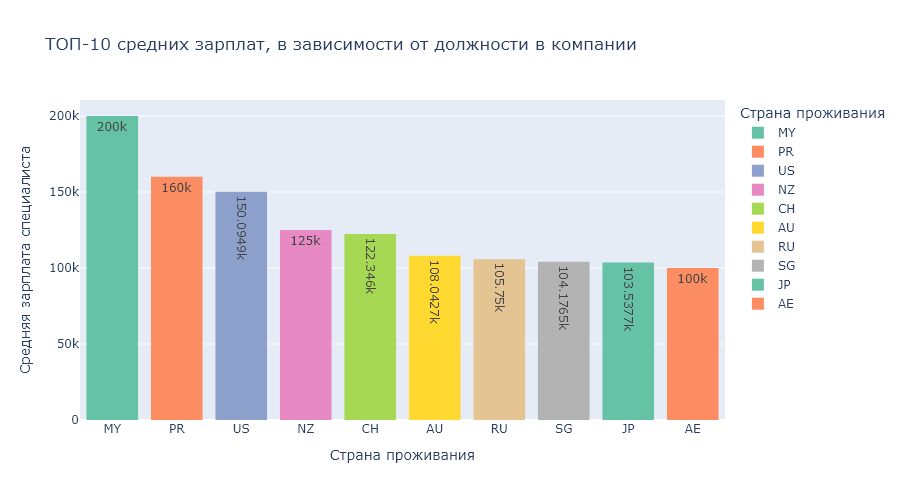

In [1753]:
grouped = data.groupby(['employee_residence'])['salary_in_usd'].mean().sort_values(ascending=False)

grouped=grouped.head(10)
fig = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    height=500, #высота
    width=900, #ширина
    labels = {'employee_residence': 'Страна проживания'},
    title = 'ТОП-10 средних зарплат, в зависимости от должности в компании',
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig.update_layout(xaxis_title_text = 'Страна проживания', yaxis_title_text='Средняя зарплата специалиста')
fig.show('png')

#### Вывод по графику: 
Больше всего сотрудников из выборки (более половины списка) проживает в US (Соединенные Штаты).
Из них в США получают среднюю зарплату - 150к.
Наибольшую среднюю зарплату получают работники из Малазии(200к) и Пуэрто-Рико(160к)

***